# Analysis of Chemicals in Cosmetic Products
# Forecasting
___

Some steps and codes of this notebook is based on the tutorial `Time Series Forecast Study with Python: Monthly Sales of French Champagne` (https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/)

## 1. Load data and Creation of Validation Dataset

#### Import libraries

In [1]:
%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

import os
import sys
import numpy    as np
import pandas   as pd
import datetime
import warnings

from matplotlib                   import pyplot
from dateutil.relativedelta       import relativedelta
from statsmodels.tsa.arima_model  import ARIMA
from sklearn.metrics              import mean_squared_error
from math                         import sqrt

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


#### Declare constants 

In [2]:
# Variables with the names of each column in data
CDPHID_COLUMN                 = 'CDPHId'
PRODUCTNAME_COLUMN            = 'ProductName'
CSFID_COLUMN                  = 'CSFId'
CSF_COLUMN                    = 'CSF'
COMPANYID_COLUMN              = 'CompanyId'
COMPANYNAME_COLUMN            = 'CompanyName'
BRANDNAME_COLUMN              = 'BrandName'
PRIMARYCATEGORYID_COLUMN      = 'PrimaryCategoryId'
PRIMARYCATEGORY_COLUMN        = 'PrimaryCategory'
SUBCATEGORYID_COLUMN          = 'SubCategoryId'
SUBCATEGORY_COLUMN            = 'SubCategory'
CASID_COLUMN                  = 'CasId'
CASNUMBER_COLUMN              = 'CasNumber'
CHEMICALID_COLUMN             = 'ChemicalId'
CHEMICALNAME_COLUMN           = 'ChemicalName'
INITIALDATEREPORTED_COLUMN    = 'InitialDateReported'
MOSTRECENTDATEREPORTED_COLUMN = 'MostRecentDateReported'
DISCONTINUEDDATE_COLUMN       = 'DiscontinuedDate'
CHEMICALCREATEDAT_COLUMN      = 'ChemicalCreatedAt'
CHEMICALUPDATEDAT_COLUMN      = 'ChemicalUpdatedAt'
CHEMICALDATEREMOVED_COLUMN    = 'ChemicalDateRemoved'
CHEMICALCOUNT_COLUMN          = 'ChemicalCount'

# Number to replace empty value in CSFId column
CSFID_EMPTY_NUMBER  = -1
# Date value which means NaT 
NAT_DATE            = datetime.date(1900,1,1)

# List of columns which contains a Names
list_names = [ PRODUCTNAME_COLUMN, CSF_COLUMN, COMPANYNAME_COLUMN, BRANDNAME_COLUMN, 
               PRIMARYCATEGORY_COLUMN, SUBCATEGORY_COLUMN, CHEMICALNAME_COLUMN ]

# List of columns which contains a Dates
list_dates = [ INITIALDATEREPORTED_COLUMN, MOSTRECENTDATEREPORTED_COLUMN, DISCONTINUEDDATE_COLUMN,
               CHEMICALCREATEDAT_COLUMN, CHEMICALUPDATEDAT_COLUMN, CHEMICALDATEREMOVED_COLUMN ]

# Other columns
list_ids   = [ CDPHID_COLUMN, CSFID_COLUMN, COMPANYID_COLUMN, PRIMARYCATEGORYID_COLUMN, 
               SUBCATEGORYID_COLUMN, CASID_COLUMN, CHEMICALID_COLUMN ]

# Path to save the images
IMAGES_PATH   = 'img'

# Format of images
IMAGES_FORMAT = '.png'

# Path where is the dataset
DATA_PATH = 'data'

# Path where is the backup dataset
DATA_BACKUP_PATH = 'data_backup'

# File name of dataset
DATA_NAME = 'cscpopendata.csv'

---

### 1.1. Load data

#### From data/ folder 

In [3]:
# Load data from data/ folder
data = pd.read_csv(os.path.join(DATA_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

# pd.isna() --> for NaN
# <value> is pd.NaT --> for NaT

# Fill NaT with 01/01/1900
for date_column in list_dates :
    data[date_column] = data[date_column].apply(lambda x: NAT_DATE if x is pd.NaT else x)
    

# Fill NA with ''
data = data.fillna('')

# Fill CSFId empty with -1
data[CSFID_COLUMN] = data[CSFID_COLUMN].apply(lambda x: x if x != "" else CSFID_EMPTY_NUMBER)

# Remove all rows that have a cosmetic product discontinued
data = data[data[DISCONTINUEDDATE_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Remove all rows that have a chemical removed
data = data[data[CHEMICALDATEREMOVED_COLUMN].apply(lambda x: x.year) == NAT_DATE.year]

# Group by InitialDateReported and sum ChemicalCount
data = pd.DataFrame(data.groupby(INITIALDATEREPORTED_COLUMN)
                    .agg({CHEMICALCOUNT_COLUMN : 'sum'}))

#### From data_backup/ folder 

In [4]:
# Load data from data_backup/ folder
data_backup = pd.read_csv(os.path.join(DATA_BACKUP_PATH, DATA_NAME), sep = ',', parse_dates = list_dates)

---

### 1.2. Creation of Validation Dataset

As the dataset is updated frequently, we are going to use it to create a validation dataset with the new data. We storage two data version: 

- The last data version in `data/` folder.
- The previous data version in `data_backup/` folder.

With that, we are going to split data as following:

- `dataset` variable will be the dataset with we are going to fit the model. This dataset will contain all data until the 5 previous months from the current month. Meaning, if the current month is 02/19 (Feb, 2019), this dataset will be contain all data until the month 09/18 (Sept, 2018): the last date in dataset will be 31/08/18 (Aug 31, 2018).
- `validation` variable will be the dataset with we are going to validate the model. This dataset will contain the rest of data.

Let's create both datasets:

In [5]:
# Get the max InitialDateReported from data
data_max = max(data.index)

# Get the max InitialDateReported from data_backup
data_backup_max = max(data_backup[INITIALDATEREPORTED_COLUMN])

print('data        | Max InitialDateReported = ', data_max)
print('data_backup | Max InitialDateReported = ', data_backup_max)

data        | Max InitialDateReported =  2019-02-21 00:00:00
data_backup | Max InitialDateReported =  2019-02-06 00:00:00


In [6]:
# Set the dataset_limit
dataset_limit = datetime.datetime(data_backup_max.year, data_backup_max.month, 1) - relativedelta(months=5)

print('Current month =', datetime.datetime(data_backup_max.year, data_backup_max.month, 1))
print('Dataset limit =', dataset_limit)

Current month = 2019-02-01 00:00:00
Dataset limit = 2018-09-01 00:00:00


In [74]:
# Set the datasets with the dataset_limit
dataset = data[data.index < dataset_limit]
validation = data[data.index >= dataset_limit]

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))

Len(dataset) = 1749
Len(validation) = 114


Our current datetime data can be tricky to work with, therefore, we will use the averages daily chemical count for that month instead, and we are using the start of each month as the timestamp.

In [75]:
dataset.head()

,ChemicalCount
InitialDateReported,
2009-07-01,4
2009-07-09,1
2009-07-13,6
2009-07-14,18
2009-08-10,4


In [78]:
dataset = dataset.resample('7D').mean().dropna()
validation = validation.resample('7D').mean().dropna()

print('Len(dataset) =', len(dataset))
print('Len(validation) =', len(validation))
dataset.head()

Len(dataset) = 223
Len(validation) = 12


,ChemicalCount
InitialDateReported,
2009-07-01,7.250000
2009-07-29,2.500000
2009-08-12,38.125000
2009-08-26,194.800000
2009-09-09,201.692308


---

## 2. Grid Search ARIMA Hyperparameters 

#### Functions definition 

In [53]:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        # difference data
        months_in_year = 12
        diff = difference(history, months_in_year)
        model = ARIMA(diff, order=arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        yhat = inverse_difference(history, yhat, months_in_year)
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))
    return best_cfg

---

#### Search hyperparameters 

We will search all combinations of the following parameters:

- p: 0 to 3.
- d: 0 to 2.
- q: 0 to 3.

This is (4 * 3 * 4), or 48, potential runs of the test harness.

In [61]:
# evaluate parameters
p_values = range(0, 4)
d_values = range(0, 2)
q_values = range(0, 4)
warnings.filterwarnings("ignore")
best_cfg = evaluate_models(dataset.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=91.902
ARIMA(0, 0, 2) RMSE=92.984
ARIMA(0, 1, 1) RMSE=90.804
ARIMA(0, 1, 2) RMSE=92.524
ARIMA(0, 1, 3) RMSE=93.346
ARIMA(1, 0, 0) RMSE=86.997
ARIMA(1, 0, 1) RMSE=92.028
ARIMA(1, 0, 2) RMSE=92.981
ARIMA(1, 0, 3) RMSE=92.815
ARIMA(1, 1, 0) RMSE=100.235
ARIMA(1, 1, 2) RMSE=92.225
ARIMA(1, 1, 3) RMSE=93.281
ARIMA(2, 0, 0) RMSE=90.863
ARIMA(2, 0, 1) RMSE=92.133
ARIMA(2, 0, 2) RMSE=91.906
ARIMA(2, 0, 3) RMSE=93.240
ARIMA(2, 1, 0) RMSE=103.707
ARIMA(2, 1, 1) RMSE=91.945
ARIMA(3, 0, 0) RMSE=92.944
ARIMA(3, 0, 1) RMSE=92.836
ARIMA(3, 0, 2) RMSE=93.646
ARIMA(3, 1, 0) RMSE=100.337
ARIMA(3, 1, 1) RMSE=93.139
ARIMA(3, 1, 2) RMSE=91.102
ARIMA(3, 1, 3) RMSE=90.299
Best ARIMA(1, 0, 0) RMSE=86.997


We will select this ARIMA(1, 0, 0) model going forward.

---

## 3. Review Residual Errors

A good final check of a model is to review residual forecast errors.

Ideally, the distribution of residual errors should be a Gaussian with a zero mean.

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(1, 0, 0) model. Let's calculate and summarize the residual forecast errors:

                0
count  234.000000
mean     1.468930
std     87.171005
min   -517.111450
25%    -28.148905
50%     -0.974329
75%     22.583191
max    572.245422


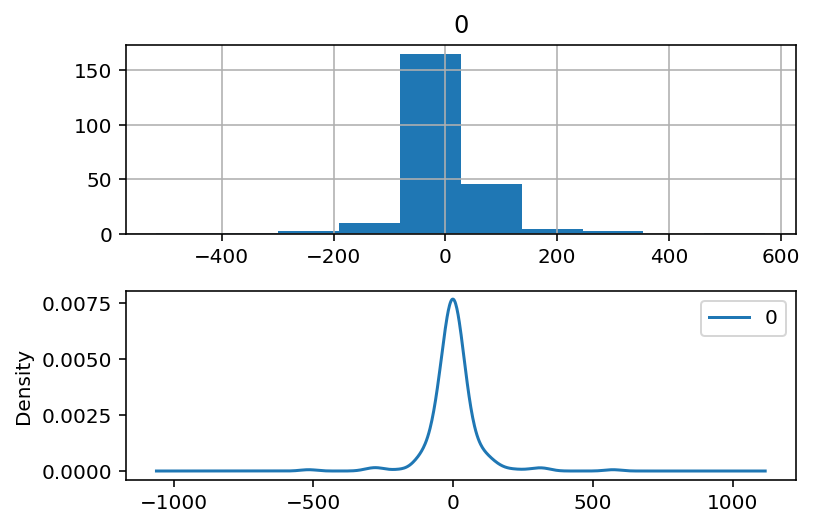

In [62]:
# prepare data
X = dataset.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = test[i]
    history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
print(residuals.describe())
# plot
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The summary of the forecast residual errors shows that the mean was indeed moved to a value very close to zero. So, the predictions are not biased.

---

## 4. Model Validation 

### 4.1. Finalize Model 

In [63]:
# prepare data
X = dataset.values
X = X.astype('float32')

# difference data
months_in_year = 12
diff = difference(X, months_in_year)

# fit model
model = ARIMA(diff, order=best_cfg)
model_fit = model.fit(trend='nc', disp=0)

### 4.2. Make Prediction 

In [64]:
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(dataset.values, yhat, months_in_year)
print('Predicted: %.3f' % yhat)

Predicted: 70.676


In [65]:
validation[CHEMICALCOUNT_COLUMN][0]

34.2

>Predicted=70.676, Expected= 34
>Predicted=45.427, Expected= 45
>Predicted=54.303, Expected=274
>Predicted=176.014, Expected= 21
>Predicted=84.851, Expected= 28
>Predicted=127.601, Expected= 16
>Predicted=-40.231, Expected= 32
>Predicted=169.103, Expected=  6
>Predicted=113.507, Expected= 20
>Predicted=-9.896, Expected= 24
>Predicted=-7.783, Expected= 38
>Predicted=128.983, Expected= 20
>Predicted=-12.371, Expected= 43
>Predicted=49.168, Expected= 33
>Predicted=268.317, Expected= 22
>Predicted=-98.459, Expected= 47
>Predicted=40.370, Expected= 56
>Predicted=29.532, Expected= 65
>Predicted=55.213, Expected= 32
>Predicted=5.406, Expected= 44
>Predicted=37.547, Expected=208
>Predicted=112.715, Expected= 60
>Predicted=55.422, Expected=125
>Predicted=60.023, Expected= 30
>Predicted=48.071, Expected= 10
RMSE: 104.489


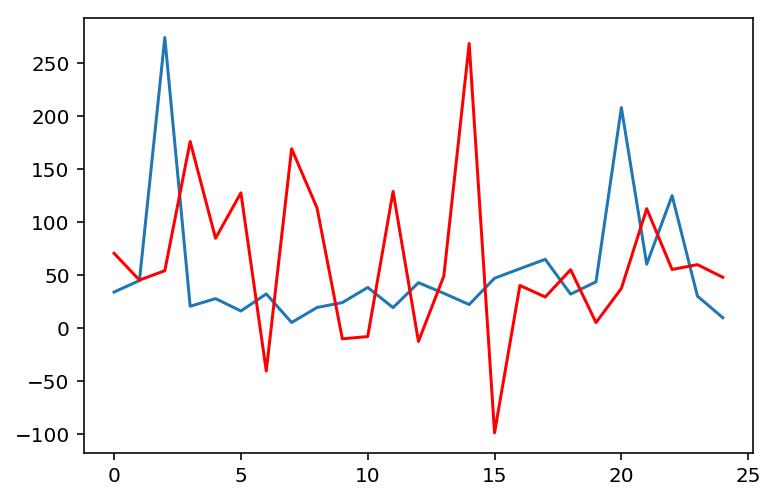

In [66]:
# prepare datasets
X = dataset.values.astype('float32')
history = [x for x in X]
months_in_year = 12
y = validation.values.astype('float32')

# make first prediction
predictions = list()
yhat = float(model_fit.forecast()[0])
yhat = inverse_difference(history, yhat, months_in_year)
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

# rolling forecasts
for i in range(1, len(y)):
    # difference data
    months_in_year = 12
    diff = difference(history, months_in_year)
    # predict
    model = ARIMA(diff, order=best_cfg)
    model_fit = model.fit(trend='nc', disp=0)
    yhat = model_fit.forecast()[0]
    yhat = inverse_difference(history, yhat, months_in_year)
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
    
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()